## (i) Importing the necessary packages

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout, GRU
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

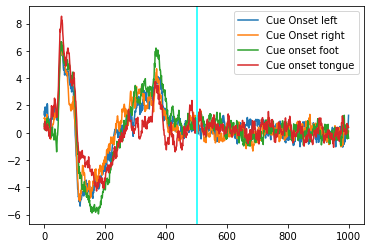

In [4]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


y_train_valid -= 769
y_test -= 769

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=400',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





In [5]:
def data_prep(X,y,sub_sample,average,noise):
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [6]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test ,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
'''print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)'''
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('y_train_valid_prep', y_train_valid_prep.shape)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)

y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
'''print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)
'''

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
y_train_valid_prep (8460,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (1772, 250, 1, 22)


# (iii) Model Architecture

## Basic GRU 

In [12]:
gru_model = Sequential()


gru_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
gru_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
gru_model.add(BatchNormalization())
gru_model.add(Dropout(0.5))

gru_model.add(Flatten()) 
gru_model.add(Dense(50))
gru_model.add(Reshape((50,1)))

gru_model.add(GRU(10, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=False))

gru_model.add(Dense(4, activation='softmax')) 


gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 84, 1, 25)        0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 84, 1, 25)        100       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 84, 1, 25)         0         
                                                                 
 flatten_2 (Flatten)         (None, 2100)              0         
                                                                 
 dense_4 (Dense)             (None, 50)               

In [ ]:
learning_rate = 0.001
epochs= 50
opt = tf.keras.optimizers.Adam(learning_rate=0.learning_rate)

In [13]:
gru_model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=['accuracy'])


gru_results = gru_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/50
109/109 [==============================] - 39s 237ms/step - loss: 1.3878 - accuracy: 0.2786 - val_loss: 1.3240 - val_accuracy: 0.3707
Epoch 2/50
109/109 [==============================] - 26s 236ms/step - loss: 1.3300 - accuracy: 0.3494 - val_loss: 1.2287 - val_accuracy: 0.4507
Epoch 3/50
109/109 [==============================] - 26s 235ms/step - loss: 1.2503 - accuracy: 0.4259 - val_loss: 1.0882 - val_accuracy: 0.5473
Epoch 4/50
109/109 [==============================] - 26s 235ms/step - loss: 1.1521 - accuracy: 0.4967 - val_loss: 0.9845 - val_accuracy: 0.5727
Epoch 5/50
109/109 [==============================] - 25s 228ms/step - loss: 1.0953 - accuracy: 0.5297 - val_loss: 0.9611 - val_accuracy: 0.5847
Epoch 6/50
109/109 [==============================] - 26s 236ms/step - loss: 1.0570 - accuracy: 0.5499 - val_loss: 0.9170 - val_accuracy: 0.6213
Epoch 7/50
109/109 [==============================] - 25s 229ms/step - loss: 1.0030 - accuracy: 0.5764 - val_loss: 0.8670 - val_ac

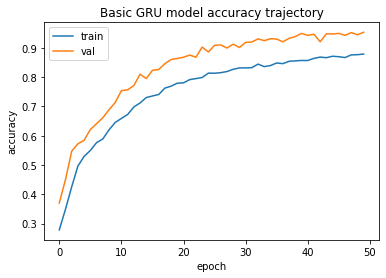

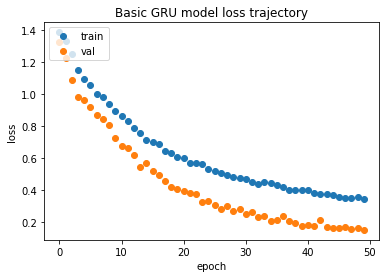

In [14]:
import matplotlib.pyplot as plt


plt.plot(gru_results.history['accuracy'])
plt.plot(gru_results.history['val_accuracy'])
plt.title('Basic GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(gru_results.history['loss'],'o')
plt.plot(gru_results.history['val_loss'],'o')
plt.title('Basic GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
cnn_score = gru_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6410835385322571


In [24]:
person_test = np.load("person_test.npy")
person_test=np.reshape(person_test,(person_test.shape[0],))
print(person_test.shape)
person_train_valid=np.reshape(person_train_valid,(person_train_valid.shape[0],))
print(person_train_valid.shape)

_ , person_test_prep = data_prep(X_test,person_test,2,2,True)
print(person_test_prep.shape)

person_test= person_test_prep
print('Shape of test labels:',person_test.shape)
for i in range(9):
  score_person = gru_model.evaluate(x_test[person_test.T==i], y_test[person_test.T==i], verbose=0)
  print("Test accuracy person " + str(i) +  " " + str(score_person[1]))

(443,)
(2115,)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(1772,)
Shape of test labels: (1772,)
Test accuracy person 0 0.5849999785423279
Test accuracy person 1 0.47999998927116394
Test accuracy person 2 0.6349999904632568
Test accuracy person 3 0.6549999713897705
Test accuracy person 4 0.7340425252914429
Test accuracy person 5 0.6479591727256775
Test accuracy person 6 0.6650000214576721
Test accuracy person 7 0.6549999713897705
Test accuracy person 8 0.7234042286872864


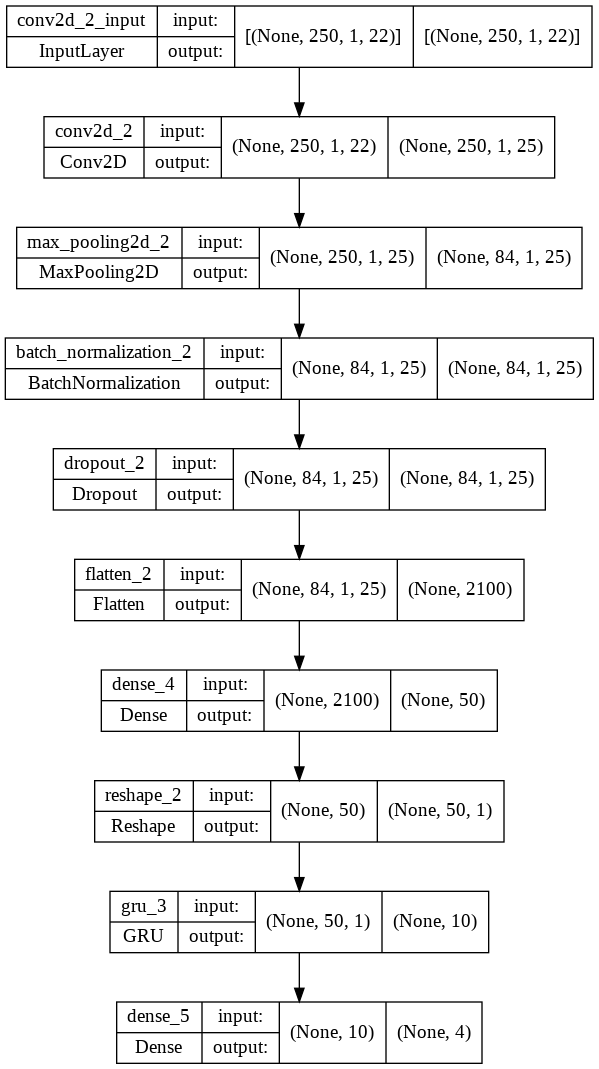

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(gru_model, show_shapes=True, show_layer_names=True, to_file='gru_model.png')

## CNN + GRU

In [17]:
gru_3 = Sequential()


gru_3.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
gru_3.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
gru_3.add(BatchNormalization())
gru_3.add(Dropout(0.5))

gru_3.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
gru_3.add(MaxPooling2D(pool_size=(3,1), padding='same'))
gru_3.add(BatchNormalization())
gru_3.add(Dropout(0.5))

gru_3.add(Flatten()) 
gru_3.add(Dense(50))
gru_3.add(Reshape((50,1)))
gru_3.add(GRU(32, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=True))
gru_3.add(GRU(64, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,32), return_sequences=True))
gru_3.add(GRU(128, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,64), return_sequences=True))

gru_3.add(Flatten())
gru_3.add(Dense(1024))
gru_3.add(Dense(4, activation='softmax'))

gru_3.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 250, 1, 50)        11050     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 84, 1, 50)        0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 84, 1, 50)        200       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 84, 1, 50)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 84, 1, 100)        50100     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 1, 100)      

In [18]:
gru_3.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

gru_results_3 = gru_3.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 78s 636ms/step - loss: 1.5215 - accuracy: 0.2862 - val_loss: 1.3090 - val_accuracy: 0.3560
Epoch 2/50
109/109 [==============================] - 68s 623ms/step - loss: 1.3240 - accuracy: 0.3665 - val_loss: 1.2541 - val_accuracy: 0.4200
Epoch 3/50
109/109 [==============================] - 68s 625ms/step - loss: 1.2167 - accuracy: 0.4437 - val_loss: 1.1455 - val_accuracy: 0.4687
Epoch 4/50
109/109 [==============================] - 68s 622ms/step - loss: 1.1228 - accuracy: 0.5103 - val_loss: 0.9782 - val_accuracy: 0.5840
Epoch 5/50
109/109 [==============================] - 68s 621ms/step - loss: 1.0470 - accuracy: 0.5467 - val_loss: 0.9071 - val_accuracy: 0.6447
Epoch 6/50
109/109 [==============================] - 68s 626ms/step - loss: 0.9341 - accuracy: 0.6131 - val_loss: 0.7629 - val_accuracy: 0.7127
Epoch 7/50
109/109 [==============================] - 69s 633ms/step - loss: 0.8768 - accuracy: 0.6466 - val_loss: 0.6957 - val_ac

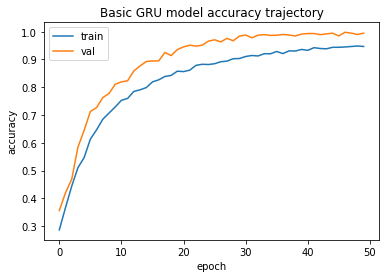

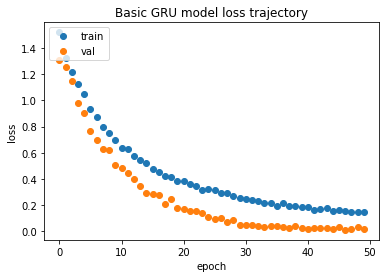

In [19]:
import matplotlib.pyplot as plt

plt.plot(gru_results_3.history['accuracy'])
plt.plot(gru_results_3.history['val_accuracy'])
plt.title('Basic GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(gru_results_3.history['loss'],'o')
plt.plot(gru_results_3.history['val_loss'],'o')
plt.title('Basic GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
cnn_score = gru_3.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6585778594017029


In [23]:
person_test = np.load("person_test.npy")
person_test=np.reshape(person_test,(person_test.shape[0],))
print(person_test.shape)
person_train_valid=np.reshape(person_train_valid,(person_train_valid.shape[0],))
print(person_train_valid.shape)
## Preprocessing the dataset
_ , person_test_prep = data_prep(X_test,person_test,2,2,True)
print(person_test_prep.shape)

person_test= person_test_prep
print('Shape of test labels:',person_test.shape)
for i in range(9):
  score_person = gru_3.evaluate(x_test[person_test.T==i], y_test[person_test.T==i], verbose=0)
  print("Test accuracy person " + str(i) +  " " + str(score_person[1]))

(443,)
(2115,)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(1772,)
Shape of test labels: (1772,)
Test accuracy person 0 0.675000011920929
Test accuracy person 1 0.5
Test accuracy person 2 0.6100000143051147
Test accuracy person 3 0.7850000262260437
Test accuracy person 4 0.7180851101875305
Test accuracy person 5 0.6632652878761292
Test accuracy person 6 0.6899999976158142
Test accuracy person 7 0.5600000023841858
Test accuracy person 8 0.7340425252914429


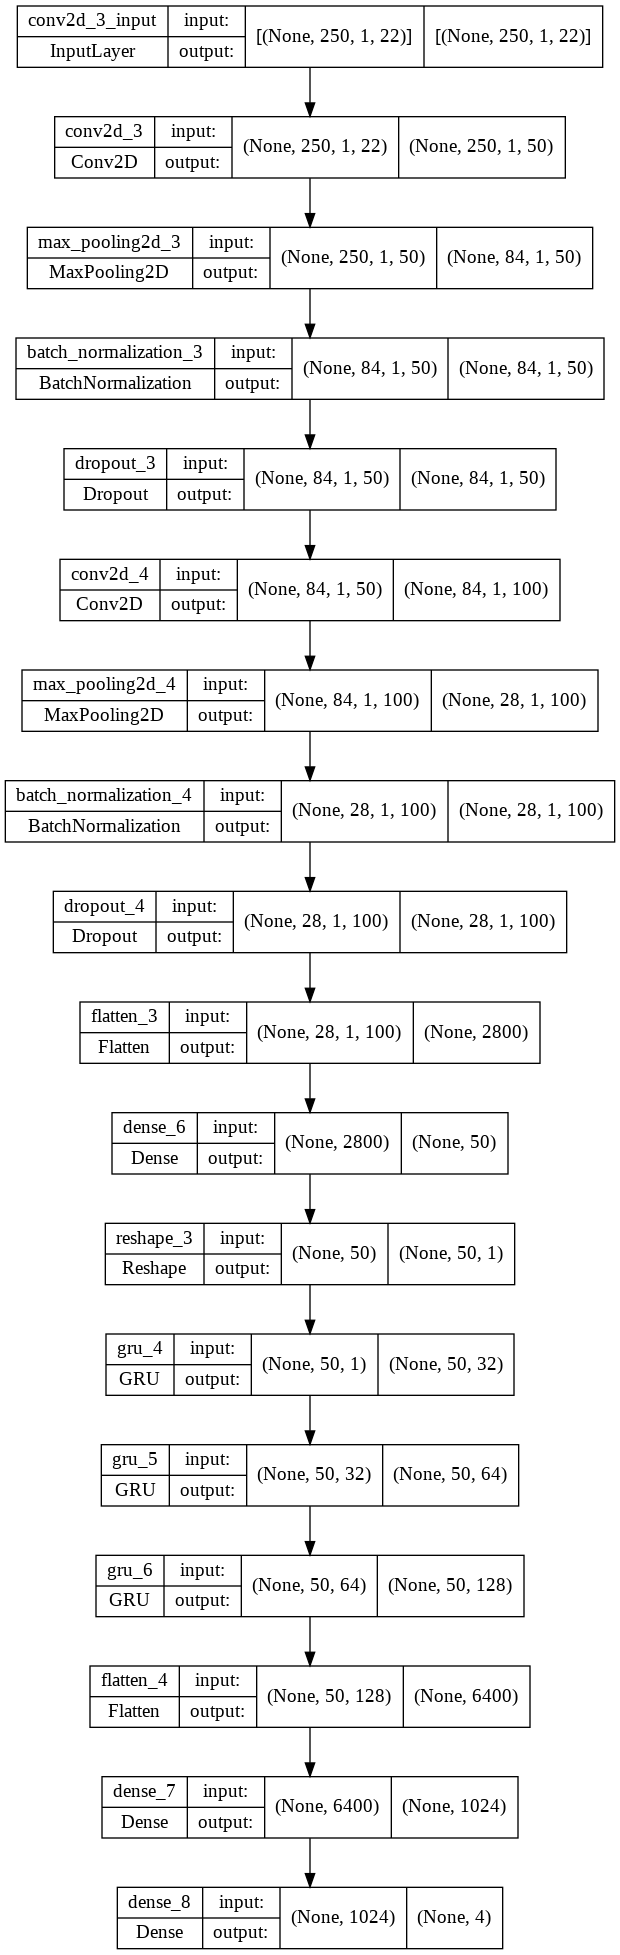

In [21]:
plot_model(gru_3, show_shapes=True, show_layer_names=True, to_file='deepcnn_gru.png')

# CNN + GRU

In [ ]:
gru_4 = Sequential()


gru_4.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
gru_4.add(MaxPooling2D(pool_size=(3,1), padding='same')) on
gru_4.add(BatchNormalization())
gru_4.add(Dropout(0.5))

gru_4.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
gru_4.add(MaxPooling2D(pool_size=(3,1), padding='same'))
gru_4.add(BatchNormalization())
gru_4.add(Dropout(0.5))

gru_4.add(Flatten())
gru_4.add(Dense(50))
gru_4.add(Reshape((50,1)))
gru_4.add(GRU(32, dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1), return_sequences=False))
gru_4.add(Reshape((32,1)))
gru_4.add(GRU(64, dropout=0.5, recurrent_dropout=0.5, input_shape=(32,1), return_sequences=False))
gru_4.add(Reshape((64,1)))
gru_4.add(GRU(128, dropout=0.5, recurrent_dropout=0.5, input_shape=(64,1), return_sequences=False))

gru_4.add(Flatten())
gru_4.add(Dense(64))
gru_4.add(Dense(4, activation='softmax'))

gru_4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 50)        11050     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 50)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 50)        200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 50)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 100)        50100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 100)       0

In [ ]:
gru_4.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])


gru_results_4 = gru_4.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)

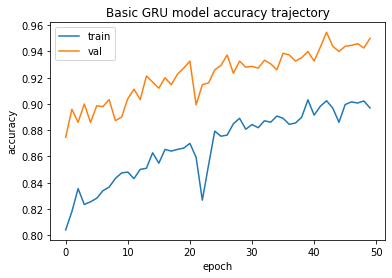

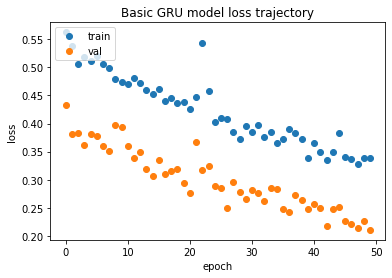

In [ ]:
plt.plot(gru_results_4.history['accuracy'])
plt.plot(gru_results_4.history['val_accuracy'])
plt.title('Basic GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(gru_results_4.history['loss'],'o')
plt.plot(gru_results_4.history['val_loss'],'o')
plt.title('Basic GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cnn_score = gru_4.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6151241660118103


# CNN + GRU

In [ ]:
from tensorflow.keras.layers import Input, Add

input_shape=(250,1,22)
inputs = Input(input_shape)
gru_5 = Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu')(inputs)
gru_5 = MaxPooling2D(pool_size=(3,1), padding='same')(gru_5)
gru_5 = (BatchNormalization())(gru_5)
gru_5 = (Dropout(0.5))(gru_5)
gru_5 = residual_block(gru_5, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)

gru_5 = Conv2D(filters=64, kernel_size=(10,1), padding='same', activation='elu')(gru_5)
gru_5 = MaxPooling2D(pool_size=(3,1), padding='same')(gru_5)
gru_5 = (BatchNormalization())(gru_5)
gru_5 = (Dropout(0.5))(gru_5)
gru_5 = Flatten()(gru_5)
gru_5 = (Dense(units=100))(gru_5)
gru_5 = Reshape((100,1))(gru_5)
gru_5 = GRU(32, dropout=0.5, recurrent_dropout=0.5, input_shape=(100,1), return_sequences=True)(gru_5)
gru_5 = GRU(64, dropout=0.5, recurrent_dropout=0.5, input_shape=(100,32), return_sequences=True)(gru_5)
gru_5 = Flatten()(gru_5)
gru_5 = Dense(4, activation='softmax')(gru_5)

model_gru5 = tensorflow.keras.Model(inputs, gru_5)
model_gru5.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_186 (Conv2D)            (None, 250, 1, 50)   11050       ['input_38[0][0]']               
                                                                                                  
 max_pooling2d_57 (MaxPooling2D  (None, 84, 1, 50)   0           ['conv2d_186[0][0]']             
 )                                                                                                
                                                                                           

In [ ]:
model_gru5.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

model_gru5_history = model_gru5.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/25
109/109 [==============================] - 63s 525ms/step - loss: 1.3459 - accuracy: 0.3582 - val_loss: 1.2646 - val_accuracy: 0.4340
Epoch 2/25
109/109 [==============================] - 55s 509ms/step - loss: 1.1535 - accuracy: 0.4731 - val_loss: 1.0557 - val_accuracy: 0.5447
Epoch 3/25
109/109 [==============================] - 56s 511ms/step - loss: 1.0393 - accuracy: 0.5563 - val_loss: 0.8968 - val_accuracy: 0.6260
Epoch 4/25
109/109 [==============================] - 56s 515ms/step - loss: 0.9240 - accuracy: 0.6208 - val_loss: 0.7823 - val_accuracy: 0.6980
Epoch 5/25
109/109 [==============================] - 56s 512ms/step - loss: 0.8171 - accuracy: 0.6809 - val_loss: 0.6561 - val_accuracy: 0.7473
Epoch 6/25
109/109 [==============================] - 56s 513ms/step - loss: 0.7106 - accuracy: 0.7157 - val_loss: 0.6307 - val_accuracy: 0.7567
Epoch 7/25
109/109 [==============================] - 55s 509ms/step - loss: 0.6284 - accuracy: 0.7546 - val_loss: 0.4457 - val_ac

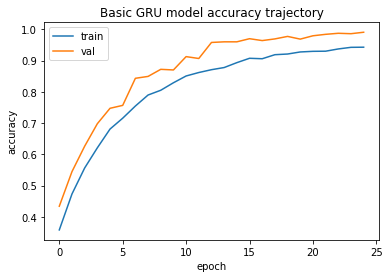

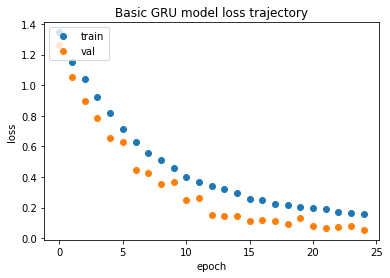

In [ ]:
plt.plot(model_gru5_history.history['accuracy'])
plt.plot(model_gru5_history.history['val_accuracy'])
plt.title('Basic GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(model_gru5_history.history['loss'],'o')
plt.plot(model_gru5_history.history['val_loss'],'o')
plt.title('Basic GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cnn_score = model_gru5.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6540632247924805


# CNN + GRU

In [ ]:
gru_6 = Sequential()

gru_6.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
gru_6.add(MaxPooling2D(pool_size=(3,1), padding='same'))
gru_6.add(BatchNormalization())
gru_6.add(Dropout(0.5))

gru_6.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
gru_6.add(MaxPooling2D(pool_size=(3,1), padding='same'))
gru_6.add(BatchNormalization())
gru_6.add(Dropout(0.5))

gru_6.add(Flatten()) 
gru_6.add(Dense(50))
gru_6.add(Reshape((50,1)))
gru_6.add(GRU(32, dropout=0.5, input_shape=(50,1), return_sequences=True))
gru_6.add(GRU(64, dropout=0.5, input_shape=(50,32), return_sequences=True))
gru_6.add(GRU(128, dropout=0.5, input_shape=(50,64), return_sequences=True))
gru_6.add(Flatten())
gru_6.add(Dense(1024))
gru_6.add(Dense(4, activation='softmax'))

gru_6.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 50)        11050     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 50)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 50)        200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 50)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 100)        50100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 100)       0

In [ ]:
gru_6.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])


gru_results_6 = gru_6.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 23s 67ms/step - loss: 1.3777 - accuracy: 0.3341 - val_loss: 1.2172 - val_accuracy: 0.4573
Epoch 2/50
109/109 [==============================] - 5s 47ms/step - loss: 1.1715 - accuracy: 0.4846 - val_loss: 1.0268 - val_accuracy: 0.5787
Epoch 3/50
109/109 [==============================] - 5s 49ms/step - loss: 1.0370 - accuracy: 0.5602 - val_loss: 0.9324 - val_accuracy: 0.6247
Epoch 4/50
109/109 [==============================] - 6s 52ms/step - loss: 0.9359 - accuracy: 0.6203 - val_loss: 0.8376 - val_accuracy: 0.6633
Epoch 5/50
109/109 [==============================] - 6s 52ms/step - loss: 0.8577 - accuracy: 0.6602 - val_loss: 0.6817 - val_accuracy: 0.7320
Epoch 6/50
109/109 [==============================] - 6s 52ms/step - loss: 0.7935 - accuracy: 0.6907 - val_loss: 0.6605 - val_accuracy: 0.7413
Epoch 7/50
109/109 [==============================] - 6s 52ms/step - loss: 0.7173 - accuracy: 0.7210 - val_loss: 0.5713 - val_accuracy: 0.780

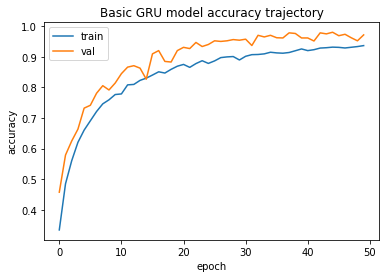

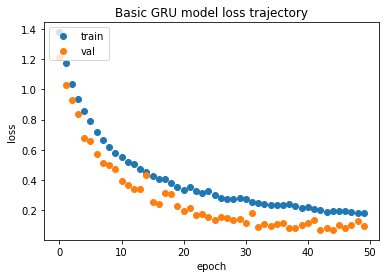

In [ ]:
plt.plot(gru_results_6.history['accuracy'])
plt.plot(gru_results_6.history['val_accuracy'])
plt.title('Basic GRU model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(gru_results_6.history['loss'],'o')
plt.plot(gru_results_6.history['val_loss'],'o')
plt.title('Basic GRU model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
cnn_score6 = gru_6.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score6[1])